# Distancia productos clientes

> Agregar bloque entrecomillado


Voy a ver de agrupar productos


*  En función de fechas inicio / fin
*  En función de distancia vectorial
Voy usar solamente la matriz final para intentar calcular las distancias, para economizar RAM


## Preparo todo

In [1]:
### me preparo en el entorno
# entorno
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    #FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    #DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    FUENTES_DIR = '/content/drive/MyDrive/MCD/Labo3/FUENTES/' # Ajustar según usuario
    DATOS_DIR = '/content/drive/MyDrive/MCD_grupo17_la_desgracia/lab3/PruebasAK/DATOSL3/' # ajustar según usuario OJO crear un acceso directo para poder "montar" una unidad compartida
else:
    # configuración para notebook con instalación LOCAL
    # FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = './DATOS/' # carpeta donde se encuentran los datasets

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Mounted at /content/drive/


In [2]:
## Cargo lo necesario
# Cargo paquetes
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from numpy.polynomial import Polynomial
#from scipy.signal import detrend



#import holidays

#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib')

In [3]:
!pip install dtaidistance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 73.7 MB/s eta 0:00:00


In [4]:
from dtaidistance import dtw
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster
import time

In [ ]:
#normailizo y guardo

#ventas_normalizadas.to_parquet(DATOS_DIR +'df_norm_pc.parquet', index=False)
#df_desvios_pc.to_csv(DATOS_DIR +'desvios_df_pc.csv', index=False)



In [5]:
df_norm_pc = pd.read_parquet(DATOS_DIR +'df_norm_pc.parquet')
df_desvios_pc = pd.read_csv(DATOS_DIR +'desvios_df_pc.csv')
df_norm_pc.head()

,2017-01-01,2017-02-01,2017-03-01,2017-04-01,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01,2018-07-01,2018-08-01,2018-09-01,2018-10-01,2018-11-01,2018-12-01,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01
0,0.938,1.875,0.872,0.125,0.953,1.208,0.954,0.409,2.729,2.095,1.052,1.238,0.468,0.834,2.025,1.253,1.563,0.870,2.415,1.313,3.382,2.313,2.273,2.401,3.646,2.923,1.231,3.436,4.149,0.622,1.365,0.317,1.028,1.660,2.232,1.700
1,1.079,0.205,0.904,0.689,0.943,1.436,0.660,0.516,1.787,0.100,1.474,1.254,1.350,0.258,1.219,1.438,1.192,0.023,0.995,1.686,0.522,0.597,0.812,3.964,0.295,0.196,0.965,1.673,0.932,4.350,1.122,0.000,2.176,0.526,1.377,3.422
2,2.067,0.295,1.986,0.993,1.947,2.464,0.932,1.205,1.017,0.897,1.812,1.938,0.612,1.116,2.746,2.701,0.403,2.428,2.044,3.970,0.048,0.971,2.889,1.425,2.601,1.170,2.462,3.314,0.027,0.000,1.992,2.335,3.360,1.095,1.241,1.473
3,1.617,0.910,2.585,2.167,1.648,1.707,3.320,2.075,1.240,3.827,1.606,0.756,3.623,1.218,2.523,1.521,2.004,2.104,1.335,3.368,1.672,4.108,0.841,2.072,0.615,1.359,0.898,0.802,3.404,0.584,2.001,0.841,2.523,2.844,1.712,0.303
4,1.308,0.354,0.354,0.059,2.601,1.308,2.971,4.628,0.426,0.422,2.227,2.109,0.304,0.836,2.516,0.312,1.030,2.027,1.647,2.211,1.050,2.362,1.072,1.326,0.448,0.312,0.473,1.520,1.089,0.000,0.566,0.000,0.877,1.174,0.837,1.343


In [6]:
## vamos a ver now dice que puede tomar series cortas, veremos
print("\nCreando la lista de series con su longitud real...")
# Changed dtype to np.double to match expected 'seq_t' type in dtaidistance C code
# Filter out empty series before creating the list
series_list_pc = [row.dropna().to_numpy(dtype=np.double) for index, row in df_norm_pc.iterrows() if not row.dropna().empty]


# Verificamos que se haya creado correctamente
print(f"Tipo de dato creado: {type(series_list_pc)}")
print(f"Número de series en la lista: {len(series_list_pc)}")
print(f"Tipo de dato del primer elemento de la lista: {type(series_list_pc[0])}")
print(f"Longitud de la primera serie: {len(series_list_pc[0])}")
if len(series_list_pc) > 0:
    print(f"Longitud de la última serie (la corta): {len(series_list_pc[-1])}")
else:
    print("No series were created (all were empty).")


Creando la lista de series con su longitud real...
Tipo de dato creado: <class 'list'>
Número de series en la lista: 302872
Tipo de dato del primer elemento de la lista: <class 'numpy.ndarray'>
Longitud de la primera serie: 36
Longitud de la última serie (la corta): 2


In [ ]:
# Esta es la parte computacionalmente más intensiva.
# dtaidistance usará todos los cores de CPU disponibles.
print("\nPaso 3: Calculando la matriz de distancias DTW...")
start_time = time.time()

# La función dtw.distance_matrix_fast es la clave.
# Utiliza una implementación en C con paralelización (OpenMP).
# `use_mp=True` activa el uso de múltiples procesadores.
ds = dtw.distance_matrix_fast(series_list_pc, use_mp=True)

end_time = time.time()
print(f"Cálculo de la matriz de distancias finalizado en {end_time - start_time:.2f} segundos.")
print(f"Dimensiones de la matriz de distancias: {ds.shape}")


Paso 3: Calculando la matriz de distancias DTW...


In [ ]:
# ==============================================================================
# 4.5. ¡NUEVO! GUARDAR LA MATRIZ DE DISTANCIAS
# ==============================================================================
print("\nPaso 4.5: Guardando la matriz de distancias en un archivo...")

# Definimos el nombre del archivo
file_path = DATOS_DIR +'dtw_distance_matrix.npy'

# Usamos np.save para guardar el array en formato binario de NumPy
np.save(file_path, ds)

print(f"Matriz guardada exitosamente en '{file_path}'.")
# Comprobamos el tamaño del archivo
#file_size_mb = os.path.getsize(file_path) / (1024 * 1024)
#print(f"Tamaño del archivo: {file_size_mb:.2f} MB")


Paso 4.5: Guardando la matriz de distancias en un archivo...
Matriz guardada exitosamente en '/content/drive/MyDrive/MCD_grupo17_la_desgracia/lab3/PruebasAK/DATOSL3/dtw_distance_matrix.npy'.


In [ ]:
# La función `linkage` de Scipy no trabaja con la matriz cuadrada completa,
# sino con una forma "condensada" (un vector con las distancias del triángulo superior).
# `squareform` hace esta conversión por nosotros. Es un paso obligatorio.
condensed_ds = squareform(ds)

print(f"Dimensiones de la matriz de distancias original: {ds.shape}")
print(f"Dimensiones de la matriz de distancias condensada: {condensed_ds.shape}")

Dimensiones de la matriz de distancias original: (1213, 1213)
Dimensiones de la matriz de distancias condensada: (735078,)


In [ ]:
# `linkage` es la función que realiza el clustering.
# Parámetros clave:
#   - condensed_ds: Tu matriz de distancias ya preparada.
#   - method='ward': El método de enlace. 'ward' es una excelente opción por defecto.
#     Busca minimizar la varianza dentro de cada cluster. Otras opciones comunes
#     son 'average', 'complete', 'single'.
model = linkage(condensed_ds, method='ward')

print("\nModelo de clustering jerárquico creado.")


Modelo de clustering jerárquico creado.


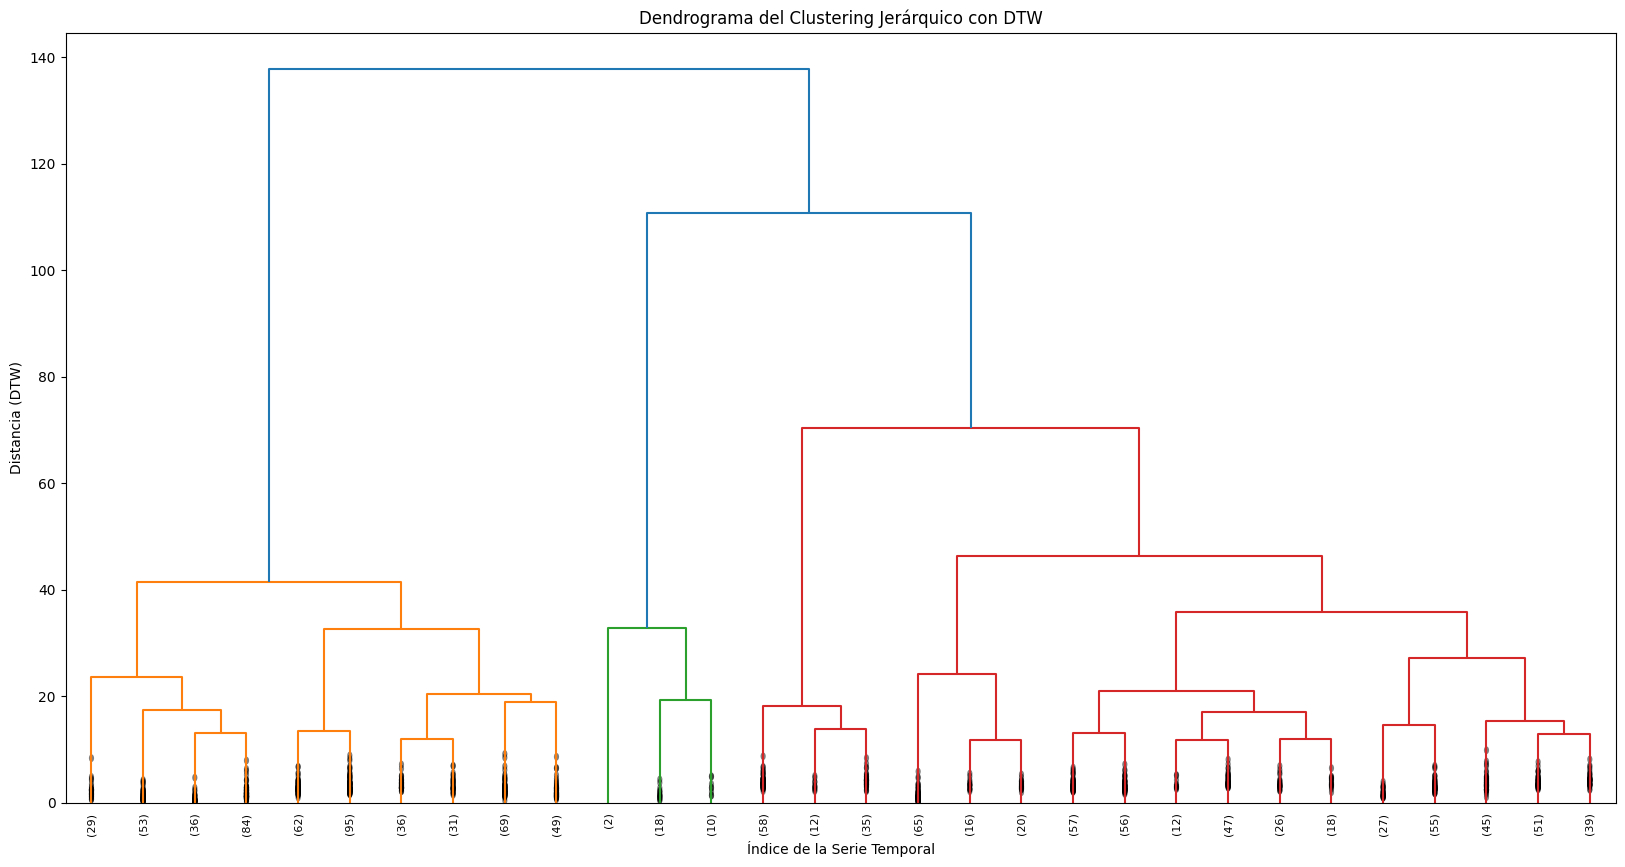

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('Dendrograma del Clustering Jerárquico con DTW')
plt.xlabel('Índice de la Serie Temporal')
plt.ylabel('Distancia (DTW)')

# `dendrogram` dibuja el árbol.
# Para datasets grandes (como el tuyo de 1250 series), es imposible etiquetar todo.
# `truncate_mode='lastp'` y `p=30` son tus mejores amigos aquí:
# Muestran los últimos 30 clusters fusionados, que es la parte más importante.
dendrogram(
    model,
    truncate_mode='lastp',  # Muestra solo los últimos 'p' clusters fusionados
    p=30,                   # El número de clusters finales a mostrar
    leaf_rotation=90.,
    leaf_font_size=8.,
    show_contracted=True,   # Para representar el tamaño de los clusters no mostrados
)
plt.show()

In [ ]:
# ==============================================================================
# 4. EXTRAER LOS CLUSTERS
# ==============================================================================


# Una vez que has visto el dendrograma, puedes "cortarlo" a una altura
# determinada o especificar el número de clusters que quieres.

# Opción A: Especificar el número de clusters (la más común)
# Mirando el dendrograma, decides que quieres, por ejemplo, 5 clusters.
num_clusters = 5
clusters = fcluster(model, t=num_clusters, criterion='maxclust')

# Opción B: Cortar por distancia (útil si tienes una idea de la escala de distancia)
# max_distancia = 20  # Por ejemplo, todos los clusters por debajo de esta distancia se fusionan
# clusters = fcluster(model, t=max_distancia, criterion='distance')

print(f"\nAsignación de clusters para las primeras 20 series (para {num_clusters} clusters):")
# `clusters` es un array donde el valor en la posición `i` es el ID del cluster
# al que pertenece la serie `i`.
for i in range(20):
    print(f"Serie {i} -> Cluster {clusters[i]}")

# Ahora puedes, por ejemplo, añadir esta información a un DataFrame para análisis posterior

df_resultados = pd.DataFrame({
    'product_id': product_ids_list,
    'cluster_id': clusters
})

# Opcional: Establecer 'product_id' como el índice del nuevo DataFrame
df_resultados.set_index('product_id', inplace=True)


print("\nDataFrame de Resultados (product_id -> cluster_id):")
print(df_resultados)

# Puedes verificar la distribución de productos por cluster
print("\nConteo de productos por cluster:")
print(df_resultados['cluster_id'].value_counts())


Asignación de clusters para las primeras 20 series (para 5 clusters):
Serie 0 -> Cluster 3
Serie 1 -> Cluster 4
Serie 2 -> Cluster 5
Serie 3 -> Cluster 5
Serie 4 -> Cluster 5
Serie 5 -> Cluster 3
Serie 6 -> Cluster 5
Serie 7 -> Cluster 5
Serie 8 -> Cluster 3
Serie 9 -> Cluster 1
Serie 10 -> Cluster 5
Serie 11 -> Cluster 5
Serie 12 -> Cluster 3
Serie 13 -> Cluster 5
Serie 14 -> Cluster 3
Serie 15 -> Cluster 5
Serie 16 -> Cluster 5
Serie 17 -> Cluster 5
Serie 18 -> Cluster 5
Serie 19 -> Cluster 5

DataFrame de Resultados (product_id -> cluster_id):
            cluster_id
product_id            
20001                3
20002                4
20003                5
20004                5
20005                5
20006                3
20007                5
20008                5
20009                3
20010                1
20011                5
20012                5
20013                3
20014                5
20015                3
20016                5
20017                5
20018    

In [ ]:
# me fijo las ventas de 3, 6,9, 12 meses y valoro los clusters
df_resultados.head()

,cluster_id
product_id,
20001,3
20002,4
20003,5
20004,5
20005,5


In [ ]:
# 3lijo y guardo clusters por producto
df_resultados.to_csv(DATOS_DIR +'df_ProdId_cluster_dtw.csv', index=False)